# Low luminosity transient searches

This notebook is prepared by Viraj Karambelkar (vk2588@columbia.edu) for the LSST CCA Summer School 2025, conducted at the Center for Computational Astrophysics from July 28 to August 8, 2025.

## Introduction
This module demonstrates how to study low-luminosity transients using time-domain surveys.

In this notebook, we will first review the landscape of low-luminosity transients, and attempt to find a low-luminosity transient by filtering through real ZTF alerts. We will look at examples of filtering alert streams to find candidate transients, followed by cross-matching with galaxy catalogs to identify potential host galaxies and estimate the absolute magnitudes of the candidates, and leverage the photometric properties to identify the transient of interest.  Finally, we will look at how archival photometric data can be used to study precursor emission and identify progenitors of transients in nearby galaxies.

## Learning Objectives
- Understand the landscape of low-luminosity transients
- Filter alert streams to find candidate low-luminosity transients
- Explore galaxy catalogs to identify potential host galaxies
- Use color and lightcurve information to examine the diversity of low luminosity transients.
- Understand how archival data can be used to study precursor emission and identify the progenitors of transients in nearby galaxies

This notebook can be done alone or in groups. However, there are three breakout discussion activities that you should do in groups, and discuss your findings with everyone.

## Required packages
pandas <br>
alerce <br>
astropy <br>
psycopg <br>
tqdm <br>
matplotlib <br>
astroquery <br>
numpy <br>
matplotlib <br>
emcee <br>
corner <br>

If you already have these packages installed, try executing the next cell - if you get no errors, your imports are likely good to go. If not, try installing these preferred versions with `pip`.

Preferred versions : <br>
numpy >=2.0.0 <br>
matplotlib>=3.10.0 <br>
astropy >= 7.0.0 <br>
pandas >= 2.2.1 <br>
psycopg == 3.2.9 <br>
astroquery == 0.4.10 <br>
tqdm == 4.67.1 <br>
emcee == 3.1.6 <br>
corner == 2.2.3 <br>


## External files
Provided in the files subdirectory
- `landscape.jpg` : A luminosity-timescale plot from Cai et al. 2022
- `mist_tracks/` : MIST stellar evolutionary tracks

In [51]:
import pandas as pd
from alerce.core import Alerce
from astropy.stats import sigma_clipped_stats
from astropy.time import Time
import psycopg
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
from astropy.io import ascii
import matplotlib
import emcee
from astropy.modeling.physical_models import BlackBody
import corner


def init():
    """
    A function to set matplotlib parameters so the plots look decent.
    """
    matplotlib.rcParams['xtick.minor.size'] = 6
    matplotlib.rcParams['xtick.major.size'] = 8
    matplotlib.rcParams['ytick.major.size'] = 8
    matplotlib.rcParams['ytick.minor.size'] = 6
    matplotlib.rcParams['lines.linewidth'] = 1.0
    matplotlib.rcParams['axes.linewidth'] = 1.0
    matplotlib.rcParams['font.size']= 18
    matplotlib.rcParams['font.family']= 'sans-serif'
    matplotlib.rcParams['xtick.major.width']= 1.5
    matplotlib.rcParams['ytick.major.width']= 1.5
    matplotlib.rcParams['ytick.direction']='in'
    matplotlib.rcParams['xtick.direction']='in'

init()

## 1. The landscape of low luminosity transients

Here is a luminosity-timescale plot (from [Cai et al. 2022](https://www.mdpi.com/2218-1997/8/10/493))

![Luminosity timescale plot](files/landscape.jpg)


In this module, we will focus on transients with peak absolute magnitudes lower than -16 and that are not necessarily fast (i.e. $\tau_{\rm{0.1dex}}>10$ days). This includes the following classes of transients ---

- Luminous Red Novae (LRNe): believed to be stellar mergers of massive stars.
- Intermediate Luminosity Red Transients (ILRTs): Unclear origins, possibly electron-capture supernovae in AGB stars.
- Luminous Blue Variable (LBV) outbursts : Massive stars undergoing outbursts.
- Classical novae : Have the lowest luminosities in this category, and are thermonuclear explosions on the surface of white dwarfs.
- Low luminosity core-collapse supernovae : Unclear origins, possibly representing explosions of the lowest mass stars that can undergo core-collapse.
- Low luminosity Type Iax supernovae : Unusual thermonuclear supernovae that are believed to originate from partial deflagrations of accreting white dwarfs that do not fully detonate the white dwarf.
- Calcium-rich transients : Unclear origins, show unusually strong calcium emission lines in their spectra.
- Other theoretically supported transients that are yet to be observationally confirmed, such as electron-capture supernovae, direct collapse of a star to a black hole, and so on.

Let's understand the detectability horizons for these transients.

Problem 1 : Plot the detection horizon distance (i.e. maximum distance out to which a transient can be detected) as a function of its r-band absolute magnitude, for ZTF (limiting magnitude = 20.5 mag) and LSST (limiting magnitude = 24 mag). Keep in mind milestone-distances of the Magellanic Clouds (~ 50 kpc), M31 (~ 1 Mpc), and the Virgo Cluster (~ 20 Mpc). Examine the differences in detectability between ZTF and LSST.

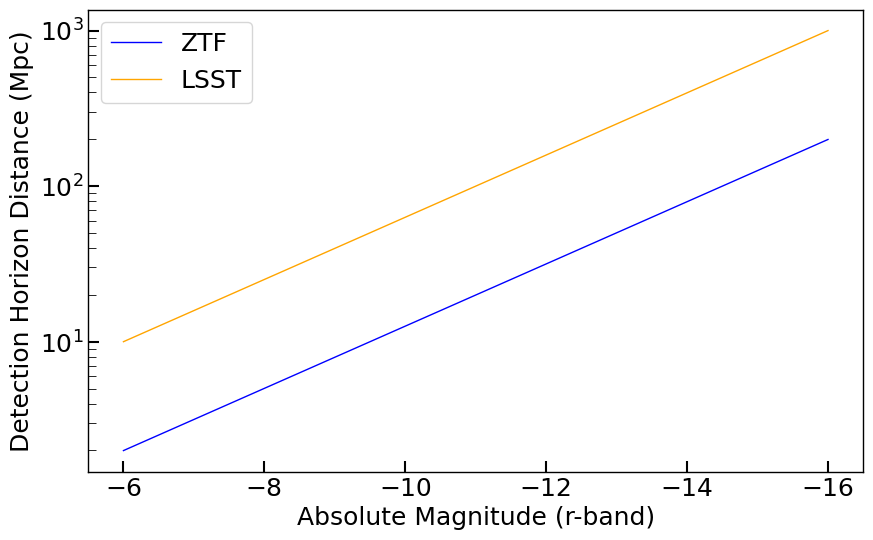

In [18]:
abs_mags = np.linspace(-6, -16, 50)
ztf_lim_mag = 20.5
lsst_lim_mag = 24.0
ztf_dists = 10**((ztf_lim_mag - abs_mags + 5) / 5)/1e6 * u.Mpc
lsst_dists = 10**((lsst_lim_mag - abs_mags + 5) / 5)/1e6 * u.Mpc
plt.figure(figsize=(10, 6))
plt.plot(abs_mags, ztf_dists, label='ZTF', color='blue')
plt.plot(abs_mags, lsst_dists, label='LSST', color='orange')
plt.xlabel('Absolute Magnitude (r-band)')
plt.ylabel('Detection Horizon Distance (Mpc)')

plt.xlim(-5.5, -16.5)
plt.legend()
plt.yscale('log')

How would you go about identifying these low-luminosity transients in a survey like ZTF?
For starters, it would be great if we could determine the absolute magnitudes of the transients. To do this, we need to know the distance to the transient. We can use galaxy catalogs to identify potential host galaxies, and then use the redshift of the host galaxy to calculate the distance.

Fortunately, there are many galaxy redshift surveys that have compiled galaxy catalogs in the local universe. Some catalogs that are commonly used in transient science are ---
- GLADE galaxy catalog : https://arxiv.org/abs/2110.06184
- CLU galaxy catalog : https://arxiv.org/abs/1710.05016
- NED Local Volume Survey catalog : https://arxiv.org/abs/2306.06271
- DESI redshift catalog : https://ned.ipac.caltech.edu/Documents/Holdings/Sets/DESI-EDR

### Breakout 1
There are many different galaxy catalogs available in the market. Take some time to find what catalogs exist, read their specifications, and understand their differences. What are some considerations that you would need to make in order to choose an appropriate galaxy catalog? Which ones will be the most relevant for the Rubin era?

In practice, cross-matching to galaxy catalogs and filtering only sources with the luminosities of interest results in a substantial reduction of alert volume. However, we still need to filter out other contaminants such as stars, AGNs, incorrect host-associations, image-subtraction artifacts, etc. Let us now dive into real ZTF data and try identifying a Luminous Red Nova.

## 2. Identifying a Luminous Red Nova in ZTF data

In this part, let us search through ZTF alerts for a Luminous Red Nova (LRN). As a reminder, LRNe are transients believed to originate in stellar mergers following common-envelope evolution in binary systems. They are also termed as "gap-transients", because they have luminosities between classical novae and supernovae. Extragalactic LRNe have massive progenitors, and have peak absolute magnitudes between -10 and -16. They also have a characteristic double-peaked lightcurve that starts off blue (sometimes showing a pronounced blue peak) and then evolves to redder colors over time.

Start by examining the ZTF alert stream from the first seven days of February 2021. We will use the ALerce alert broker to query for ZTF alerts.

In [8]:
start_date = '2021-02-01T00:00:00'
end_date = '2021-02-07T00:00:00'

start_date_mjd = Time(start_date).mjd
end_date_mjd = Time(end_date).mjd

First, let us find out how many alerts were first detected in this period. We will use the ALeRCE database to do this, as it contains all ZTF alerts from 2018 onwards, and is available through a public API.

In [313]:
# These credentials is publicly sourced from https://github.com/alercebroker/usecases/blob/master/alercereaduser_v4.json, in case
# you were (rightly) panicking about potential security breaches
params =  {
        "dbname" : "ztf",
        "user" : "alerceread",
        "host": "54.205.99.47",
        "password" : "w*C*u8AXZ4e%d+zv"
}

In [90]:
conn = psycopg.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])
# Query the database to get the number of alerts in the specified period
query = "select object.oid from object where object.firstMJD > 59246 and object.firstMJD < 59253;"
result = pd.read_sql_query(query, conn)
print(f"Number of alerts first detected in the period {start_date} to {end_date}: {len(result)}")

/var/folders/1d/r0f_wd9x10v1pb53kt5hsjg00000gn/T/ipykernel_82614/654809605.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(query, conn)


Number of alerts first detected in the period 2021-02-01T00:00:00 to 2021-02-07T00:00:00: 459620


OK there are almost 500k alerts that were first detected in these seven days. We need to filter through them to identify a Luminous Red Nova that erupted during this time. Let us do that using the Alerce public API.

First, query all alerts that had at least three ZTF detections, and were first detected during this period. (You might have to run the query in batches.)

In [62]:
# Query all ZTF alerts from ALeRCE in this period using the API

alerce = Alerce()
query_ended = False
counter = 1
all_alerts = pd.DataFrame()
while not query_ended:
    alerts = alerce.query_objects(
        format='pandas',
        firstmjd=[start_date_mjd, end_date_mjd],
        page=counter,
        page_size=10000,
        ndet = [3, 99999],
    )
    if (len(alerts) == 0) or (counter > 10):
        query_ended = True
    all_alerts = pd.concat([all_alerts, alerts], ignore_index=True)
    counter += 1

In [63]:
print(f"Retrieved a total of {len(all_alerts)} alerts first detected in the period {start_date} to {end_date} "
      f"with the criteria : At least 3 detections")

Retrieved a total of 55700 alerts first detected in the period 2021-02-01T00:00:00 to 2021-02-07T00:00:00 with the criteria : At least 3 detections


Filter out stars, using the 'stellar' column from alerce


In [95]:
all_alerts = all_alerts[all_alerts['stellar'] == False]
print(f"After filtering out stars, we have {len(all_alerts)} alerts left.")

After filtering out stars, we have 40476 alerts left.


As we are interested in low luminosity transients, we need a way to identify the redshift of the transient. This is where galaxy catalogs come in.

Here, let us cross-match this list to the GLADE galaxy catalog, which is available on vizier



In [68]:
vizier = Vizier(columns=['RAJ2000', 'DEJ2000', 'GLADE_ID', 'GLADE_RA', 'GLADE_DEC', 'GLADE_z'])


In [101]:
all_alerts_crds = SkyCoord(ra=all_alerts['meanra'], dec=all_alerts['meandec'], unit='deg')

In [123]:
xmatched_alerts = pd.DataFrame()
for i in tqdm(range(0, len(all_alerts_crds), 1000)):
    alerts_batch = all_alerts_crds[i:i+1000]
    alerts_sub_df = all_alerts.iloc[i:i+1000]
    result = Vizier.query_region(alerts_batch, radius=70*u.arcsec, catalog='VII/281/glade2')
    if i == 0:
        if len(result) == 0:
            print("No matches found in the GLADE catalog.")
            all_galaxies = pd.DataFrame()
        else:
            # The result is a list of tables, we take the first one
            all_galaxies = result[0]
    else:
        if len(result) > 0:
            # Concatenate the new results to the existing dataframe
            xmatch_sub_df = alerts_sub_df.iloc[result[0]['_q'] - 1]
            # sideways concatenate the GLADE results to the existing dataframe
            glade_df = result[0].to_pandas()
            xmatch_sub_df = pd.concat([xmatch_sub_df.reset_index(drop=True), glade_df.reset_index(drop=True)], axis=1)

            xmatched_alerts = pd.concat([xmatched_alerts, xmatch_sub_df], ignore_index=True)

100%|██████████| 41/41 [04:54<00:00,  7.19s/it]


In [125]:
print(f"Cross-matched {len(xmatched_alerts)} alerts with the GLADE galaxy catalog.")

Cross-matched 2386 alerts with the GLADE galaxy catalog.


Nice! Already down by a factor of 250. However this list includes several fake-associations that are likely not associated with the galaxy, but just happen to be within 70 arcsec. Let's calculate the physical distance between the transient position and the galaxy position, and filter out those that are further than 10 kpc from the galaxy.

Note that I just made up the 10 kpc number : in practice this will depend on the types of transients you are interested in.

In [186]:
galaxy_crds = SkyCoord(ra=xmatched_alerts['RAJ2000'], dec=xmatched_alerts['DEJ2000'], unit='deg')
xmatched_alert_crds = SkyCoord(ra=xmatched_alerts['meanra'], dec=xmatched_alerts['meandec'], unit='deg')
distances_kpc = galaxy_crds.separation(xmatched_alert_crds).to(u.rad) * xmatched_alerts['Dist'] * 1e3
xmatched_alerts['dist_arcsec'] = galaxy_crds.separation(xmatched_alert_crds).to(u.arcsec).value
xmatched_alerts['dist_kpc'] = distances_kpc
xmatched_alerts = xmatched_alerts[xmatched_alerts['dist_kpc'] < 10].reset_index(drop=True)
print(f"After filtering out sources that are further than 50 kpc from the galaxy, we have {len(xmatched_alerts)} alerts left.")

After filtering out sources that are further than 50 kpc from the galaxy, we have 320 alerts left.


OK let us now query the lightcurves of these transients and use the distances to the host galaxies to calculate their peak absolute magnitudes in ZTF data.

Herea are some helper functions to query the lightcurves, thumbnails and plot them (copied from the module on GW searches)

In [20]:
# Color config for filters
colors = {1: "green", 2: "red"}
labels = {1: 'g', 2: 'r'}
markers = {1: 'o', 2: 's'}
sizes = {1: 30, 2: 60}

def plotStamps(oid, lc_det, client):
    # Find first detection with a valid stamp
    if "has_stamp" not in lc_det.columns or lc_det["has_stamp"].sum() == 0:
        print(f"⚠️ No stamp available for {oid}")
        return

    try:
        candid = lc_det.loc[lc_det.has_stamp].sort_values("mjd").candid.iloc[0]
        stamps = client.get_stamps(oid, candid, format='HDUList')
        science, ref, difference = stamps[0].data, stamps[1].data, stamps[2].data
    except Exception as e:
        print(f"❌ Failed to fetch stamps for {oid}: {e}")
        return

    # Plot the cutouts
    fig, ax = plt.subplots(ncols=3, figsize=(12, 5))
    titles = ["Science", "Reference", "Difference"]
    images = [science, ref, difference]

    for i in range(3):
        img = np.log1p(images[i])  # log scale with log1p for stability
        _, med, std = sigma_clipped_stats(img, sigma=3.0)
        ax[i].imshow(img, cmap='viridis', origin='lower')
        ax[i].set_title(titles[i])
        ax[i].axis("off")

    ax[0].set_title(f"{oid}, candid: {candid}", loc='left', fontsize=14)
    plt.tight_layout()
    plt.show()

def plotLC(oid, SN_det, SN_nondet):
    fig, ax = plt.subplots(figsize=(14, 7))

    for fid in [1, 2]:
        mask = SN_det.fid == fid
        if np.sum(mask) > 0:
            ax.errorbar(
                SN_det[mask].mjd, SN_det[mask].magpsf,
                yerr=SN_det[mask].sigmapsf,
                c=colors[fid], label=labels[fid],
                marker=markers[fid], linestyle='none'
            )

        mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
        if np.sum(mask) > 0:
            ax.scatter(
                SN_nondet[mask].mjd, SN_nondet[mask].diffmaglim,
                c=colors[fid], alpha=0.5, marker='v',
                label=f"lim.mag. {labels[fid]}", s=sizes[fid]
            )

    ax.set_title(oid, fontsize=20)
    ax.set_xlabel("MJD", fontsize=16)
    ax.set_ylabel("Apparent magnitude", fontsize=16)
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.grid(True)
    plt.tight_layout()
    plt.show()


def get_lc_data(oid, client, doLC=False, doStamps=False):
    results = {"oid": oid}

    try:
        lc_det = client.query_detections(oid, format='pandas').sort_values("mjd")
        results["lc_det"] = lc_det
    except Exception as e:
        print(f"⚠️ Could not fetch detections for {oid}: {e}")
        lc_det = pd.DataFrame()

    try:
        lc_nondet = client.query_non_detections(oid, format='pandas').sort_values("mjd")
        results["lc_nondet"] = lc_nondet
    except Exception as e:
        print(f"⚠️ Could not fetch non-detections for {oid}: {e}")
        lc_nondet = pd.DataFrame()

    # Plot light curve
    if doLC and not lc_det.empty and not lc_nondet.empty:
        plotLC(oid, lc_det, lc_nondet)

    # Plot stamps
    if doStamps and not lc_det.empty:
        plotStamps(oid, lc_det, client)

    return results

In [189]:
min_mags, all_lcs = [], {}
for ind in tqdm(range(len(xmatched_alerts))):
    row = xmatched_alerts.iloc[ind]
    oid = row['oid']
    lc_data = get_lc_data(oid, alerce, doLC=False, doStamps=False)
    all_lcs[oid] = lc_data
    if 'lc_det' in lc_data and not lc_data['lc_det'].empty:
        min_mags.append(lc_data['lc_det']['magpsf'].min())
    else:
        min_mags.append(np.nan)


100%|██████████| 320/320 [11:56<00:00,  2.24s/it]


In [197]:
min_mags, rbscores = [], []
for ind in tqdm(range(len(xmatched_alerts))):
    row = xmatched_alerts.iloc[ind]
    oid = row['oid']
    lc_data = all_lcs[oid]
    if 'lc_det' in lc_data and not lc_data['lc_det'].empty:
        min_mags.append(lc_data['lc_det']['magpsf'].min())
        rbscores.append(lc_data['lc_det']['rb'].median())
    else:
        min_mags.append(np.nan)


100%|██████████| 320/320 [00:00<00:00, 1393.21it/s]


In [198]:
xmatched_alerts['min_mag'] = min_mags
xmatched_alerts['rb'] = rbscores

Plot some of the candidates that you obtain after absolute magnitude filtering. Is there additional filtering you can do with which you can get the number of candidates lower than 10?

Let's add some more quality cuts based on the real-bogus score, the minimum apparent magnitude, total duration, and minimum number of detections (NOTE we can only add the last criterion because we are doing an archival search. If you are interested in finding these sources in realtime and when they are young, you would not want to filter on number of detections)

In [217]:
xmatched_alerts_real = xmatched_alerts[(xmatched_alerts['min_mag'] < 20)
                                       & (xmatched_alerts['rb'] > 0.5)
                                       & (xmatched_alerts['ndet'] > 10)
                                       & (xmatched_alerts['deltajd'] < 1000)
].reset_index(drop=True)
print(f"After filtering out sources with min_mag > 20 and rb < 0.5, we have {len(xmatched_alerts_real)} alerts left.")

After filtering out sources with min_mag > 20 and rb < 0.5, we have 90 alerts left.


In [218]:
xmatched_alerts_real['peak_abs_mag'] = xmatched_alerts_real['min_mag'] - 5 * np.log10(xmatched_alerts_real['Dist']*1e6/10)

In [219]:
subluminous_alerts = xmatched_alerts_real[xmatched_alerts_real['peak_abs_mag'] > -16].reset_index(drop=True)

In [220]:
print(f"After filtering out sources with peak_abs_mag > -16, we have {len(subluminous_alerts)} alerts left.")

After filtering out sources with peak_abs_mag > -16, we have 4 alerts left.


  0%|          | 0/4 [00:00<?, ?it/s]

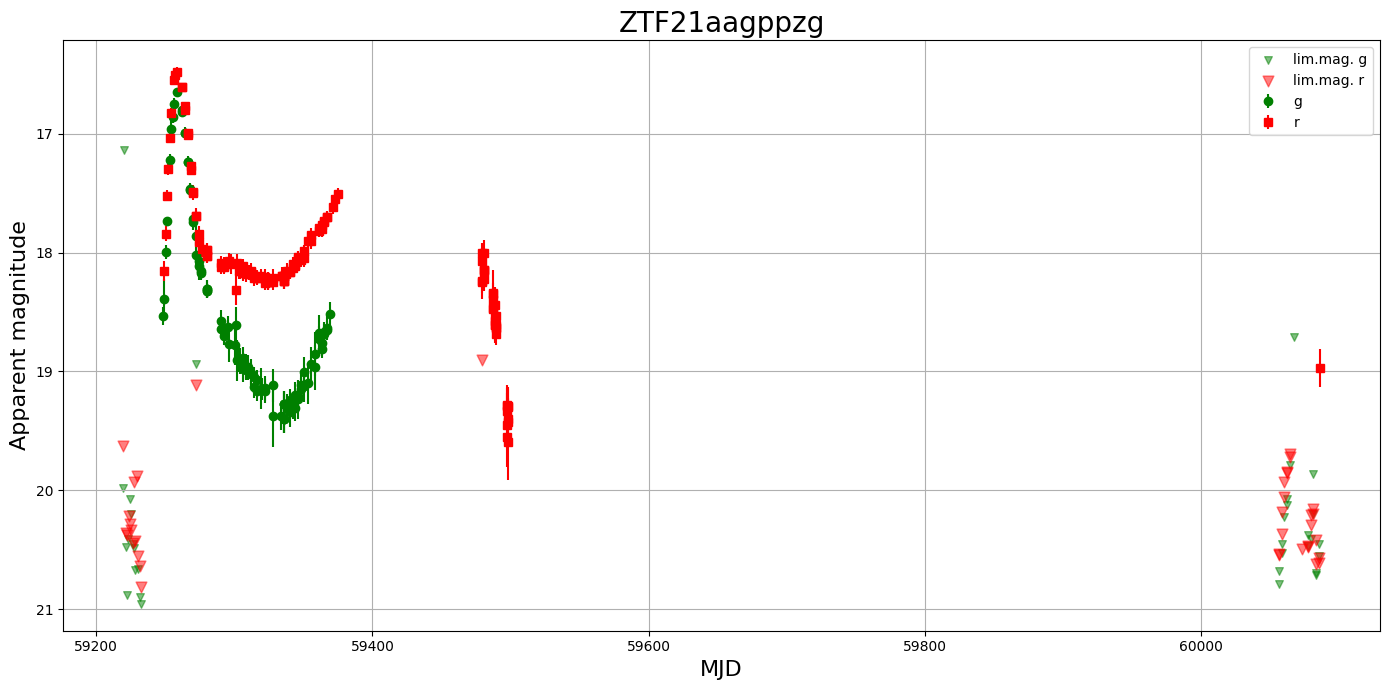

/var/folders/1d/r0f_wd9x10v1pb53kt5hsjg00000gn/T/ipykernel_82614/3415780508.py:27: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


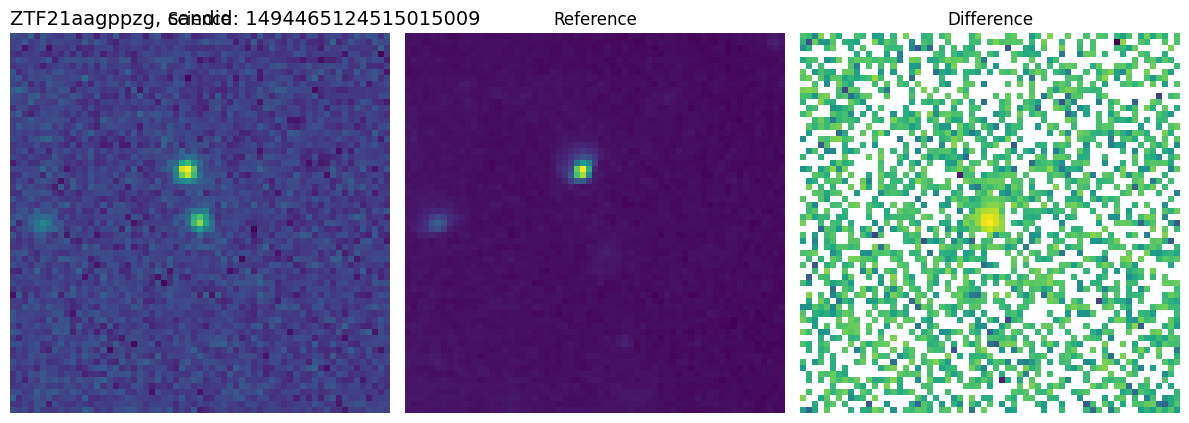

 25%|██▌       | 1/4 [00:04<00:13,  4.57s/it]

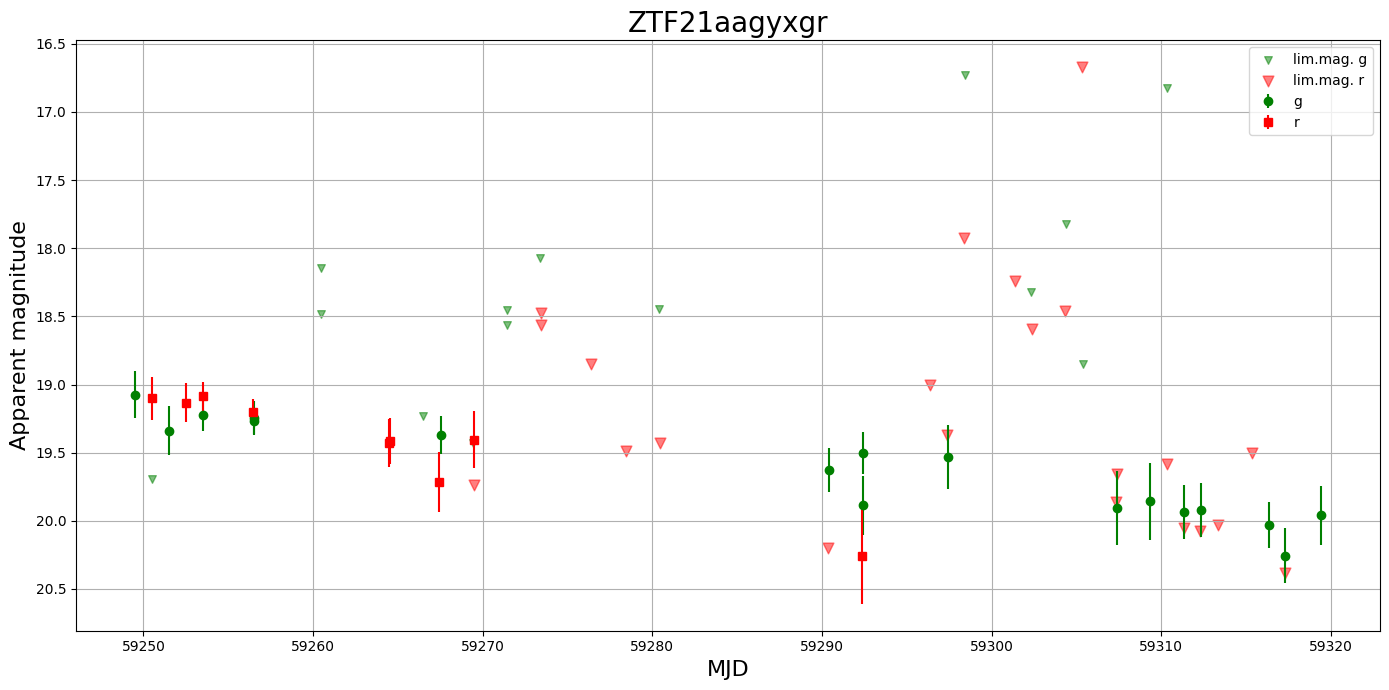

/var/folders/1d/r0f_wd9x10v1pb53kt5hsjg00000gn/T/ipykernel_82614/3415780508.py:27: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


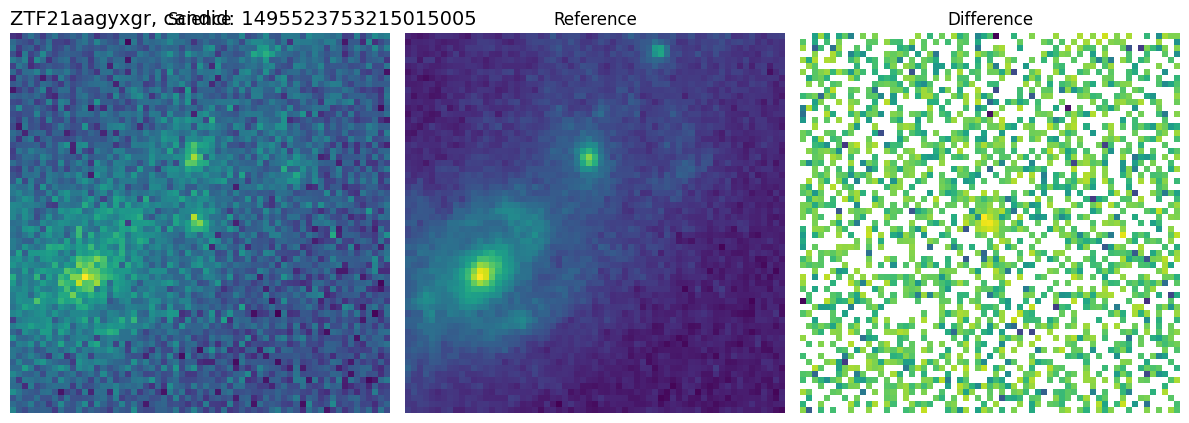

 50%|█████     | 2/4 [00:11<00:12,  6.09s/it]

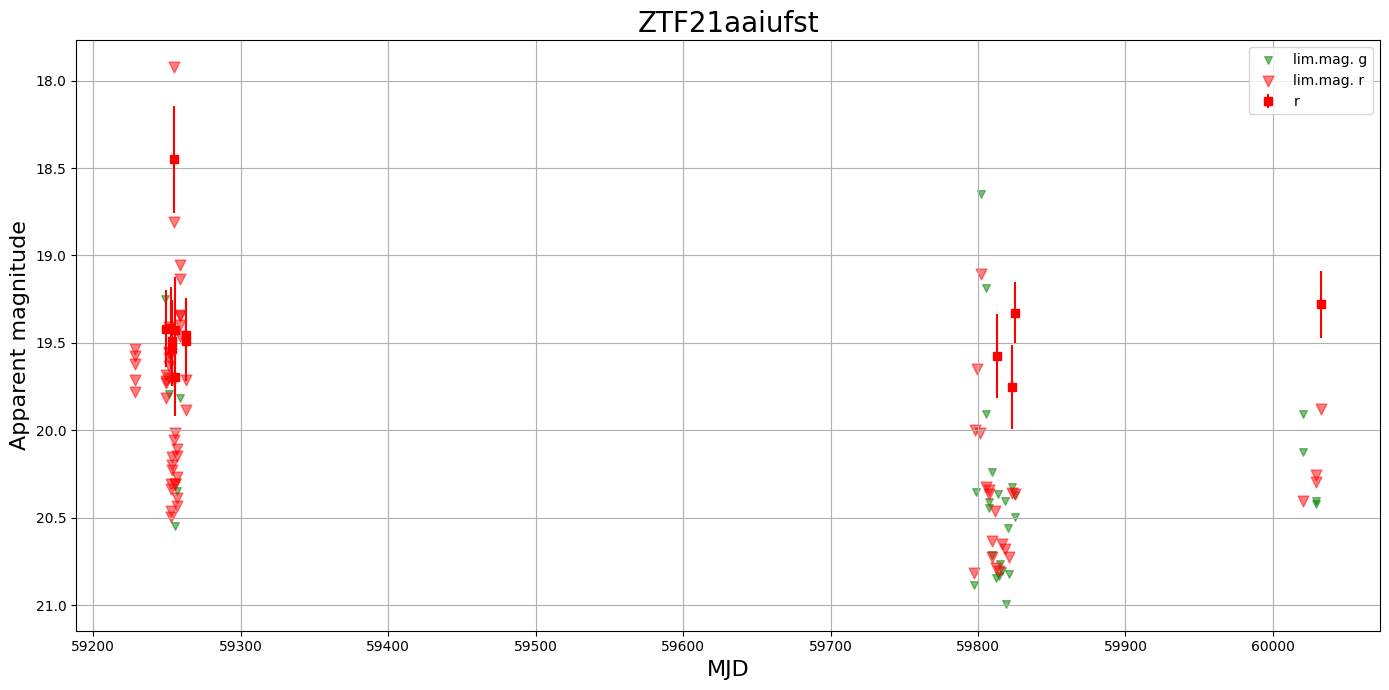

/var/folders/1d/r0f_wd9x10v1pb53kt5hsjg00000gn/T/ipykernel_82614/3415780508.py:27: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


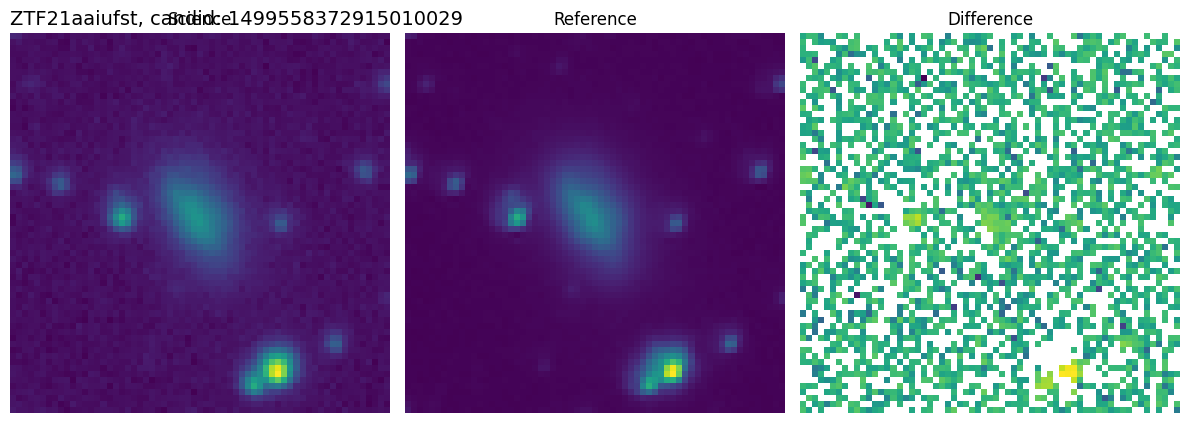

 75%|███████▌  | 3/4 [00:14<00:04,  4.44s/it]

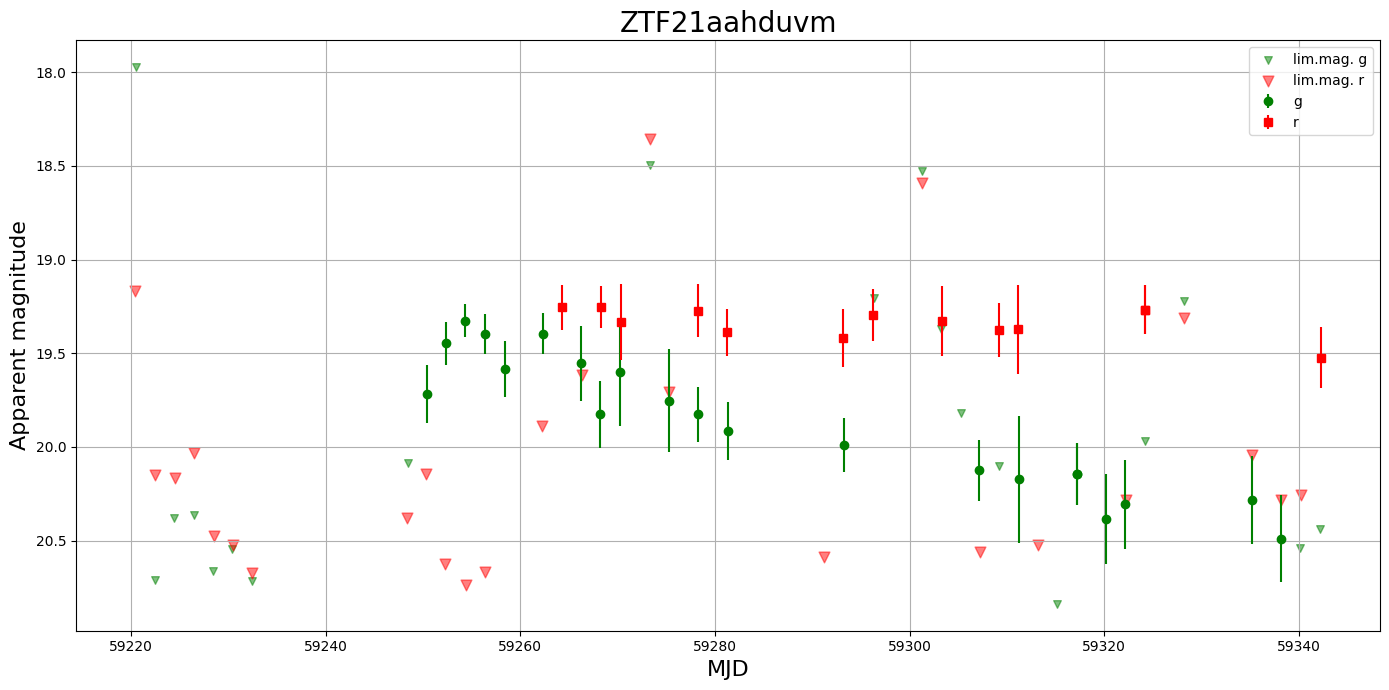

/var/folders/1d/r0f_wd9x10v1pb53kt5hsjg00000gn/T/ipykernel_82614/3415780508.py:27: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


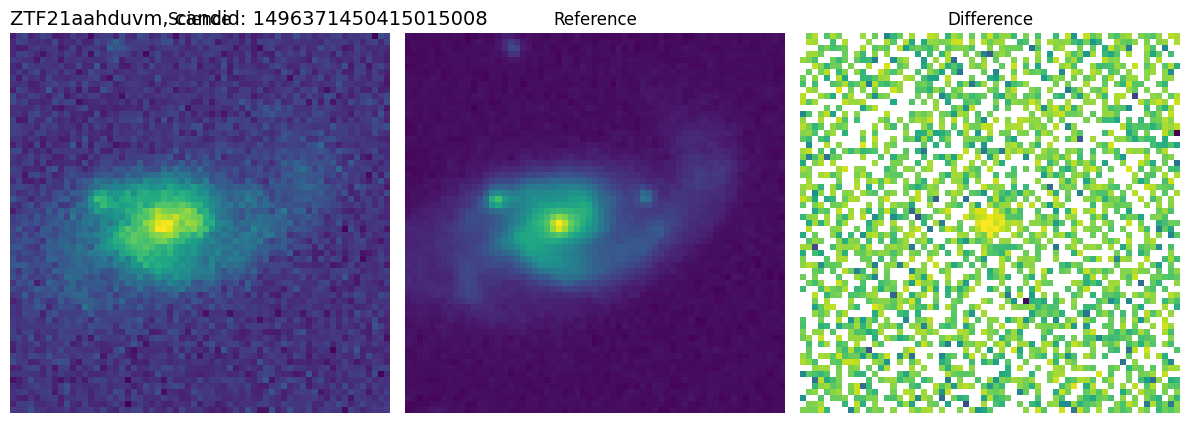

100%|██████████| 4/4 [00:16<00:00,  4.15s/it]


In [221]:
# We have reduced the list from 450k to 4! Let us plot these sources to vet them and see which ones are further interesting.
for ind in tqdm(range(len(subluminous_alerts))):
    _ = get_lc_data(
        subluminous_alerts.iloc[ind]['oid'],
        alerce,
        doLC=True,
        doStamps=True
    )

Recall that Luminous Red Novae show a double peaked lightcurve that has a blue first peak followed by a second red peak. Do any of these transients follow this description?

We have successfully recovered the Luminous Red Nova ZTF21aagppzg / AT2021blu!!

There are still some contaminants despite all our filtering. How can you get rid of them?
- A few artifacts appear to be nuclear sources. These could be AGN. Xmatching to AGN catalogs would help here
- Some transients appear to be extremely long-lived. Some have unrealistic photometric scatter.
- Some transients remain blue throughout, unlike LRNe.

Note that these filtering steps that allowed us to identify this LRN all dealt with photometric data, without requiring any spectroscopic observations! Galaxy catalogs thus provide a powerful tool to search for low luminosity transients in Rubin data. LRNe are special cases as they show a characteristic lightcurve shape, so in principle they can be identified without any spectroscopic observations.

### Breakout 2 -
- Discuss what challenges you could face while doing this. Will the LSST cadence be an issue? What will be the major contaminants in this search?
- The ZTF discovery rate of LRNe is ~2-3 every year. What would the LRN discovery rate be with Rubin?



## 3. The diversity of low luminosity transients

We have seen how to identify a LRN in ZTF data. However, there are many other low luminosity transients that can be identified in a similar way. Let us look at the lightcurves of a few more classes of low luminosity transients, and see how they differ from LRNe.

Problem 3a : Look at the lightcurves of following transients in ZTF data:
- ZTF21aagppzg : LRN
- ZTF23aajlkxc : LRN
- ZTF19aadyppr : ILRT
- ZTF19acoaiub : ILRT
- ZTF21aagydmn : Possible LBV outburst
- ZTF21aaoryiz : Low luminosity Type Iax supernova


Fetching data for ZTF21aagppzg


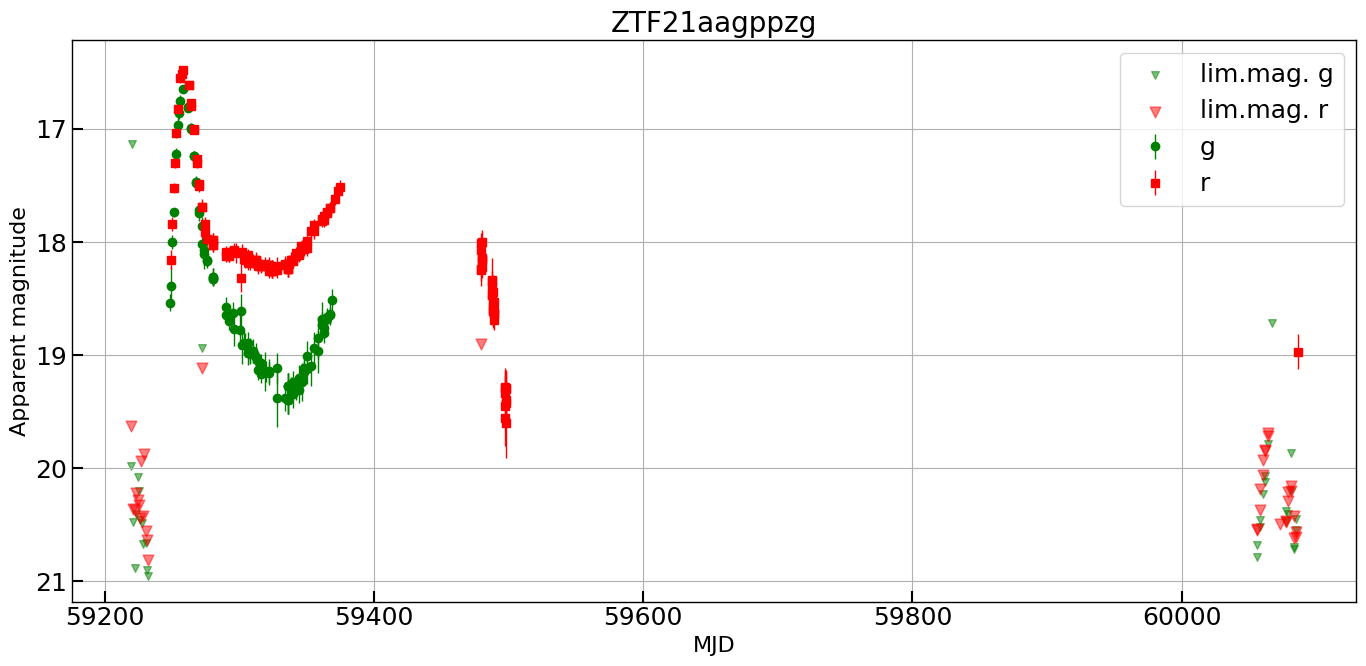

Fetching data for ZTF23aajlkxc


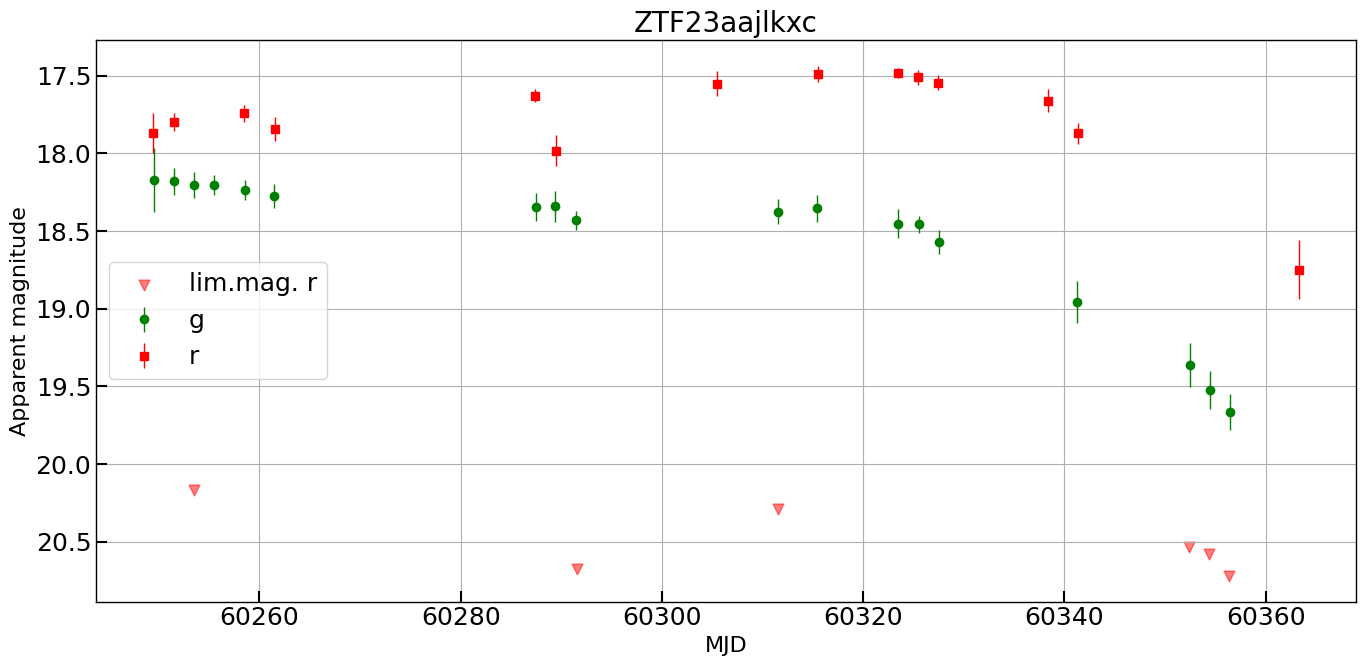

Fetching data for ZTF19aadyppr


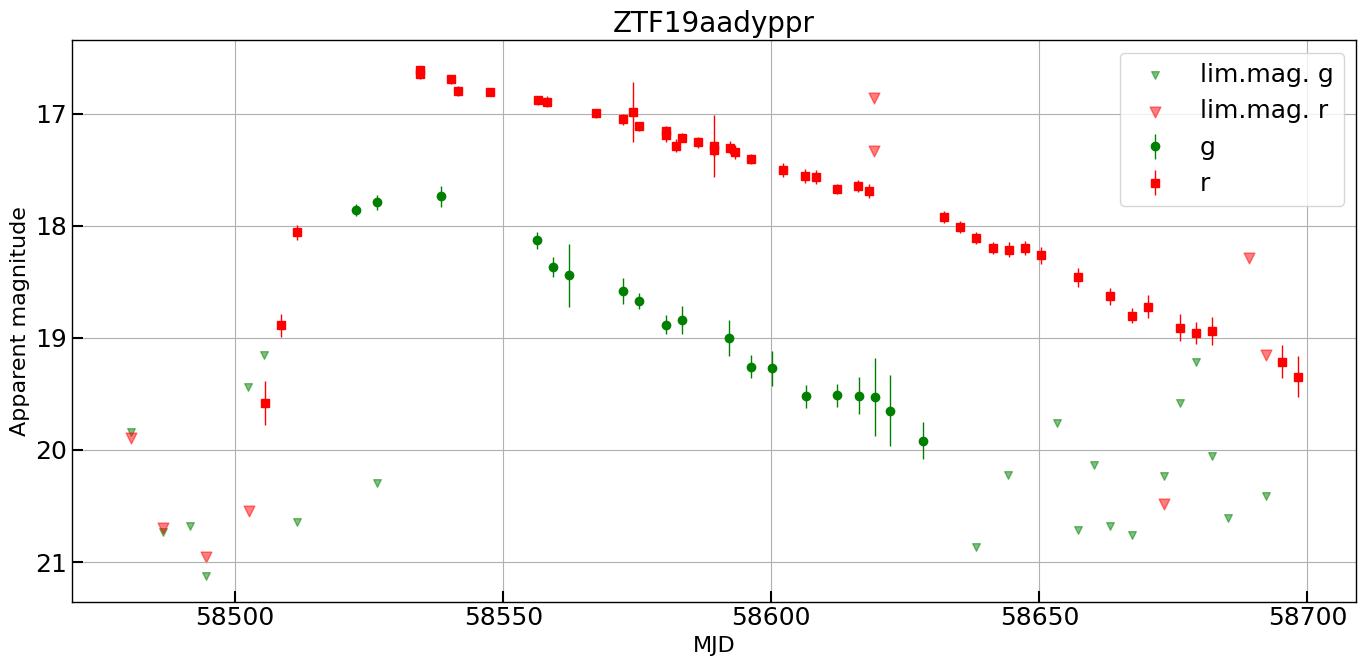

Fetching data for ZTF19acoaiub


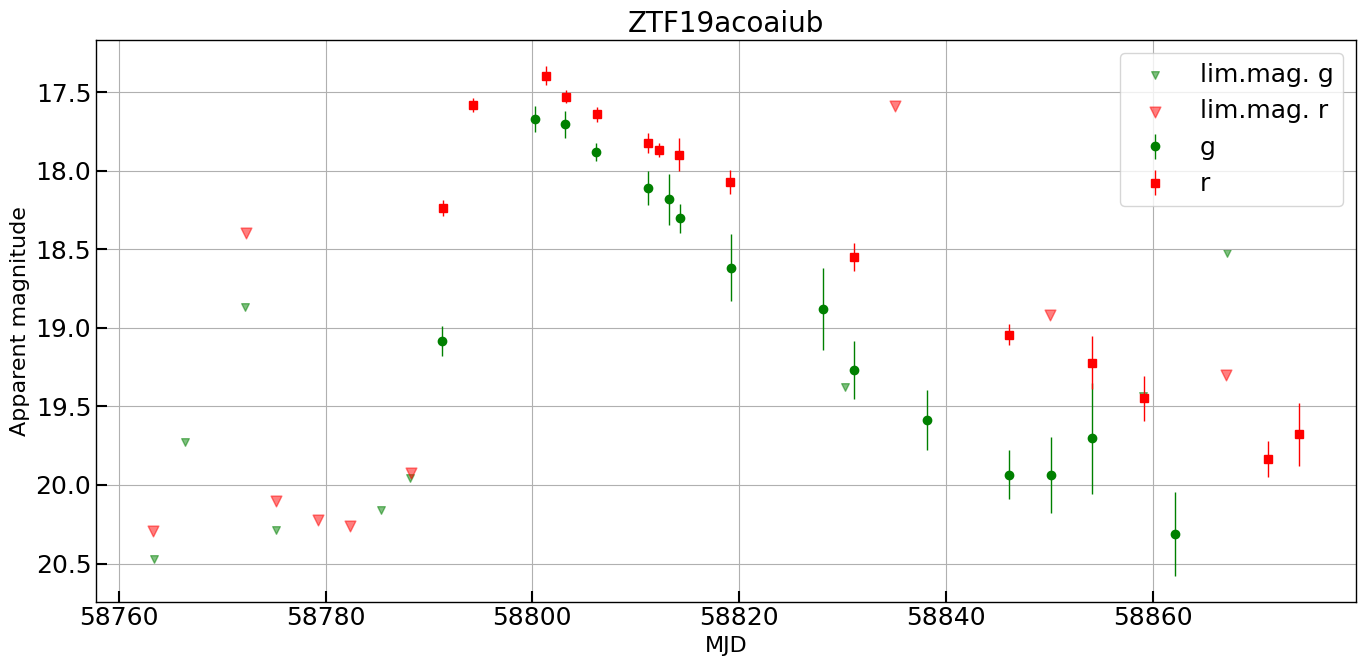

Fetching data for ZTF21aagydmn


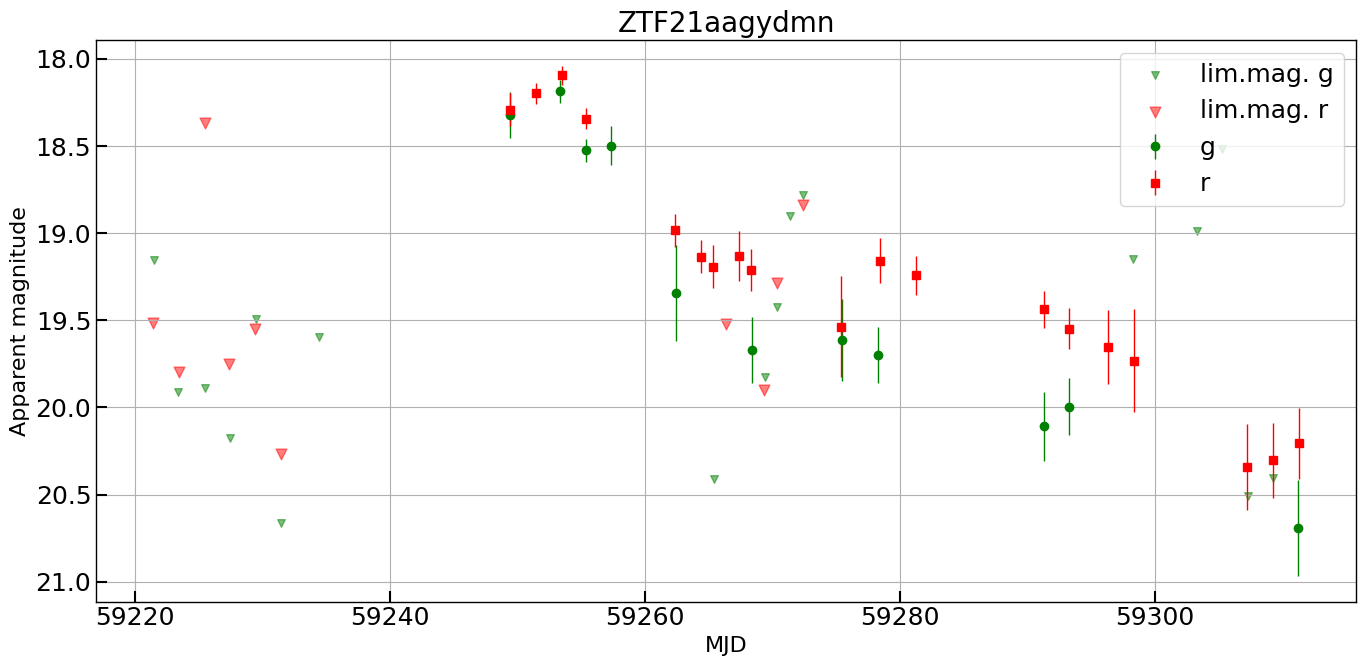

Fetching data for ZTF21aaoryiz


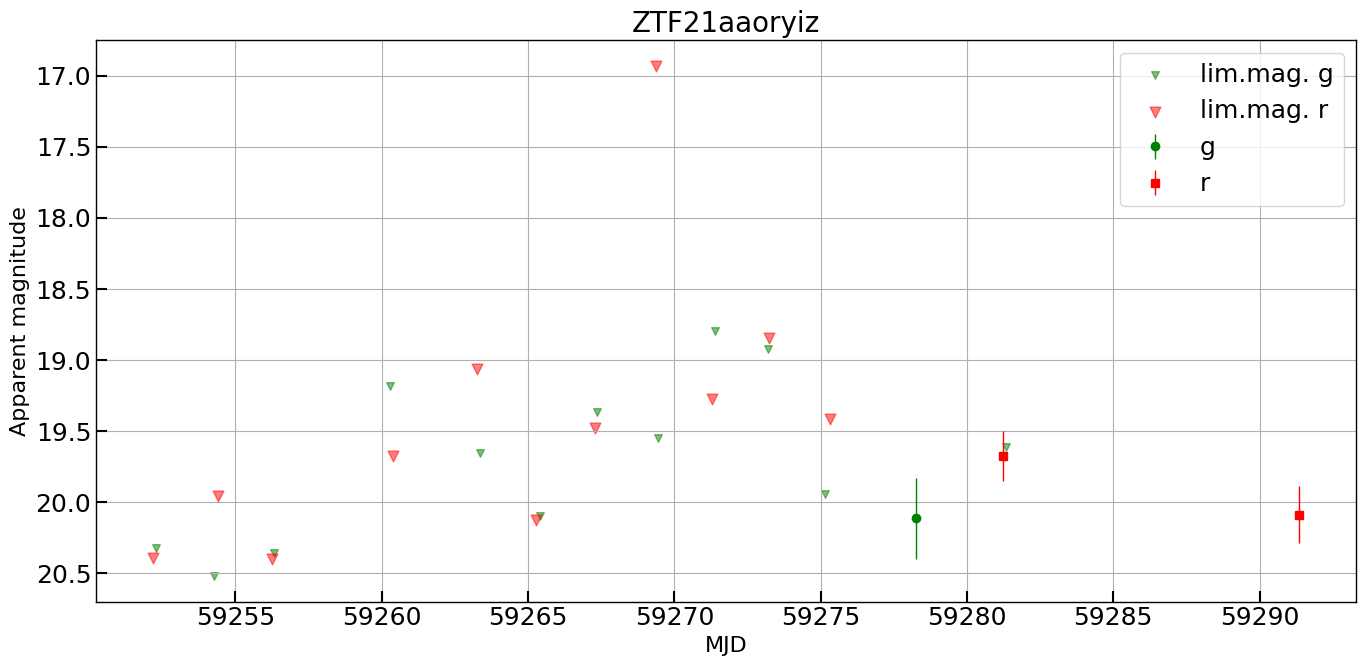

In [28]:
alerce = Alerce()
for name in ['ZTF21aagppzg', 'ZTF23aajlkxc', 'ZTF19aadyppr', 'ZTF19acoaiub', 'ZTF21aagydmn', 'ZTF21aaoryiz']:
    print(f"Fetching data for {name}")
    results = get_lc_data(
        name,
        alerce,
        doLC=True,
        doStamps=False
    )


What differences do you see in these lightcurves?

- LRNe have a characteristic double peaked lightcurve, with a blue first peak followed by a red second peak.
- ILRTs have a single peaked lightcurve that is generally redder than LRNe.
- LBVs tend to be blue, however the dustiest LBV outbursts can also be red. In general, LBVs have multiple outbursts, so archival data from other surveys can be used to flag a candidate as a possible LBV.
- Low luminosity thermonuclear transients like SNe Iax tend to fade fast.

In my experience, of the different classes of low luminosity transients, LRNe are the easiest ones to identify photometrically. The other ones are .. less easy ..

## 4. Precursor emission
A benefit of focusing on nearby transients is that they allow searching for eruption preceding and after the main outburst. Let us look at an example to illustrate this.

Problem 4a : Examine the lightcurve of the Luminous Red Nova ZTF19adakuot. This source erupted in M31, (distance modulus of 24.5). ZTF missed majority of the main eruption due to visibility constraints, but the field was observed right up to a few days after the eruption. Plot the ZTF lightcurve of this transient.


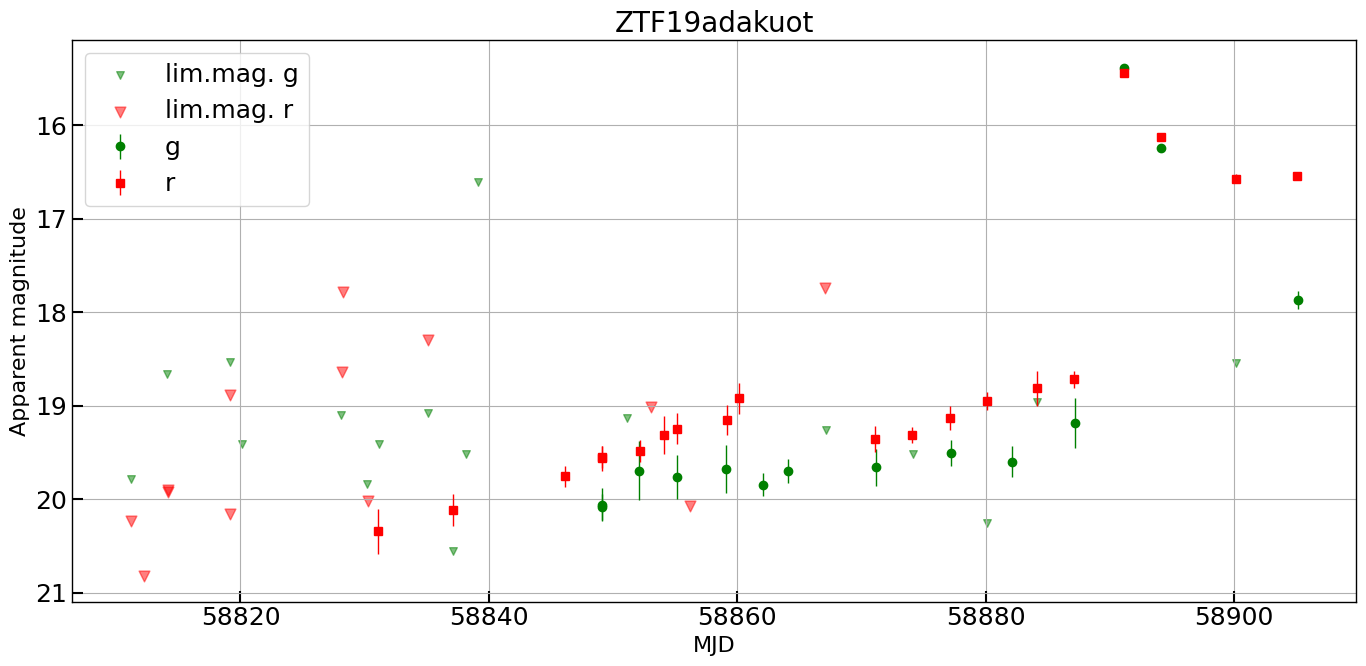

In [29]:
alerce = Alerce()
results = get_lc_data(
    'ZTF19adakuot',
    alerce,
    doLC=True,
    doStamps=False
)

We see the main eruption (absolute magnitude ~ -9) that starts off as blue and transitions rapidly to red colors. There are several detections preceding this! These precursor brightenings are believed to originate in outflows from the common-envelope prior to the merger, and thus they can tell us a lot about the common-envelope phase. However, such precursor detections are extremely rare! In fact, ZTF19adakuot is the only extragalactic LRN that has multiband precursor emission.

Problem 4b : What is the detection horizon limit for LRN precursor emission for a survey like ZTF? How does this compare to LSST? (Assume the precursors have similar luminosities as that for ZTF19adakuot)


In [31]:
ztf_lim_mag = 20.5
lsst_lim_mag = 24.0
precursor_apparent_mag = 19.0
precursor_abs_mag = precursor_apparent_mag - 24.5
ztf_dists = 10**((ztf_lim_mag - precursor_abs_mag + 5) / 5)/1e6 * u.Mpc
lsst_dists = 10**((lsst_lim_mag - precursor_abs_mag + 5) / 5)/1e6 * u.Mpc
print(f"Detection horizon distance for precursor emission with ZTF: {ztf_dists:.2f}")
print(f"Detection horizon distance for precursor emission with LSST: {lsst_dists:.2f}")

Detection horizon distance for precursor emission with ZTF: 1.58 Mpc
Detection horizon distance for precursor emission with LSST: 7.94 Mpc


## 5. Progenitor identifications

Another advantage of focusing on transients in nearby galaxies is they offer the possibility of looking at archival pre-eruption imaging to identify the progenitor system.

Let's go back to our original source ZTF21aagppzg. Check for pre-eruption images of ZTF21aagppzg. You can check for HST images [here](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html), or the Pan-STARRS images [here](https://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=&filter=color&filter=g&filter=r&filter=i&filter=z&filter=y&filetypes=stack&auxiliary=data&size=240&output_size=0&verbose=0&autoscale=99.500000&catlist=).

From Pastorello et al. 2022, the progenitor magnitudes of ZTF21aagppzg are :
M$_{r}=-6.76 \pm 0.19$, M$_{g}=-6.49 \pm 0.26$, M$_{i}=-6.87 \pm 0.28$, M$_{z} = -6.89 \pm 0.35$

Fit a blackbody to the SED of the progenitor star to estimate the temperature and luminosity of the progenitor primary star (assuming that the primary star dominates the flux measurements). Use a distance of $\approx 10$ Mpc for the host galaxy. You can use the fitting method of your choice.

<ErrorbarContainer object of 3 artists>

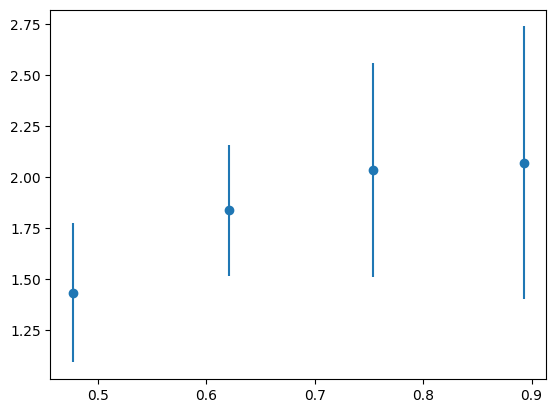

In [247]:
abs_mags = np.array([-6.49, -6.76, -6.87, -6.89])
D = 10 # Mpc
app_mags = abs_mags + 5 * np.log10(D * 1e6 / 10)  # Distance modulus for 10 Mpc
abs_maguncs = np.array([0.26, 0.19, 0.28, 0.35])
wavs_um = np.array([0.477, 0.621, 0.754, 0.893])  # g, r, i, z in microns
fnu_ujy = 10**((app_mags + 48.6) / -2.5)/1e-29
fnu_unc = np.array(abs_maguncs) * fnu_ujy / 1.0857  # Uncertainties in Jy
plt.errorbar(wavs_um, fnu_ujy, yerr=fnu_unc, fmt='o', label='Luminosity')

In [283]:
# Fit the blackbody to the data using emcee
def lnlike(theta, wavs, fnu, fnu_unc, D=10 *3.086e24):
    T = theta[0]
    R = theta[1]
    bb = BlackBody(T * u.K)
    model_fnu = (bb(wavs * u.um).value * np.pi * R**2/ D**2)/1e-29
    chi2 = np.sum(((fnu - model_fnu) / fnu_unc)**2)
    return -0.5 * chi2 if np.isfinite(chi2) else -np.inf


def lnprior(theta):
    T = theta[0]
    if 3000 < T < 100000:
        return 0.0
    return -np.inf


def lnprob(theta, wavs, fnu, fnu_unc):
    if theta[0] > 0:
        log_like = lnlike(theta, wavs, fnu, fnu_unc)
    else:
        log_like = 0
    return lnprior(theta) + log_like

100%|██████████| 500/500 [00:40<00:00, 12.30it/s]


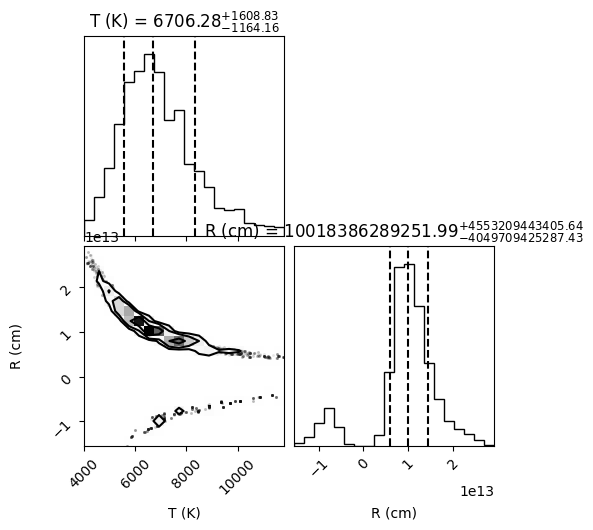

In [284]:
nwalkers = 20
ndim = 2
initial = np.array([6800, 150*7e10])  # Initial guess for T and R
initial = np.random.normal(loc=initial, scale=[50, 50*7e10], size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(wavs_um, fnu_ujy, fnu_unc))

sampler.run_mcmc(initial, 500, progress=True)

samples = sampler.get_chain(flat=True, discard=50)

fig = corner.corner(samples, labels=['T (K)', 'R (cm)'], quantiles=[0.16, 0.5, 0.84], show_titles=True)


In [298]:
print(f"Estimated temperature: {np.nanpercentile(samples[:, 0], [16, 50, 84])} K")
print(f"Estimated radius: {np.nanpercentile(samples[:, 1], [16, 50, 84])/7e10} Rsun")
lums = (4*np.pi* (samples[:, 1])**2 * 5.67e-5 * (samples[:, 0])**4)
print(f"Estimated luminosity: {np.nanpercentile(lums, [16, 50, 84])}")

Estimated temperature: [5542.11791868 6706.27682007 8315.10928506] K
Estimated radius: [ 85.26681234 143.11980413 208.16565332] Rsun
Estimated luminosity: [1.35592933e+38 1.57046351e+38 1.82388142e+38]


Plot the luminosity and temperature on an HR diagram, and compare it to MIST stellar evolutionary tracks (download the relevant tracks from https://waps.cfa.harvard.edu/MIST/model_grids.html#eeps) and derive constraints on the progenitor primary mass

In [48]:
# Helper functions to read MIST models
mist_colnames = ['star_age',
'star_mass',
'star_mdot',
'he_core_mass',
'c_core_mass',
'o_core_mass',
'log_L'      ,
'log_L_div_Ledd',
'log_LH'        ,
'log_LHe'       ,
'log_LZ'        ,
'log_Teff'      ,
'log_abs_Lgrav' ,
'log_R'         ,
'log_g'         ,
'log_surf_z'    ,
'surf_avg_omega',
'surf_avg_v_rot',
'surf_num_c12_div_num_o16',
'v_wind_Km_per_s'         ,
'surf_avg_omega_crit'   ,
'surf_avg_omega_div_omega_crit',
'surf_avg_v_crit'       ,
'surf_avg_v_div_v_crit' ,
'surf_avg_Lrad_div_Ledd',
'v_div_csound_surf',
'surface_h1'       ,
'surface_he3'      ,
'surface_he4'      ,
'surface_li7'      ,
'surface_be9'      ,
'surface_b11'      ,
'surface_c12'      ,
'surface_c13'      ,
'surface_n14'      ,
'surface_o16'      ,
'surface_f19'      ,
'surface_ne20'     ,
'surface_na23'     ,
'surface_mg24'     ,
'surface_si28'     ,
'surface_s32'      ,
'surface_ca40'     ,
'surface_ti48'     ,
'surface_fe56'     ,
'log_center_T'     ,
'log_center_Rho'   ,
'center_degeneracy',
'center_omega'     ,
'center_gamma'     ,
'mass_conv_core'   ,
'center_h1'        ,
'center_he4'       ,
'center_c12'       ,
'center_n14'       ,
'center_o16'       ,
'center_ne20'      ,
'center_mg24'      ,
'center_si28'      ,
'pp'               ,
'cno'              ,
'tri_alfa'         ,
'burn_c'           ,
'burn_n'           ,
'burn_o'           ,
'c12_c12'          ,
'delta_nu'         ,
'delta_Pg'         ,
'nu_max'           ,
'acoustic_cutoff'  ,
'max_conv_vel_div_csound',
'max_gradT_div_grada'    ,
'gradT_excess_alpha'     ,
'min_Pgas_div_P'         ,
'max_L_rad_div_Ledd'     ,
'e_thermal'              ,
'phase',]


def open_mist_model(filename):
    model = ascii.read(filename, names = mist_colnames)
    model = model[(model['phase']>=0)  & (model['phase']<=5)]
    return model

In [49]:
m10 = open_mist_model('files/mist_tracks/01000M.track.eep')
m11 = open_mist_model('files/mist_tracks/01100M.track.eep')
m12 = open_mist_model('files/mist_tracks/01200M.track.eep')
m13 = open_mist_model('files/mist_tracks/01300M.track.eep')
m14 = open_mist_model('files/mist_tracks/01400M.track.eep')
m15 = open_mist_model('files/mist_tracks/01500M.track.eep')
m16 = open_mist_model('files/mist_tracks/01600M.track.eep')
m17 = open_mist_model('files/mist_tracks/01700M.track.eep')

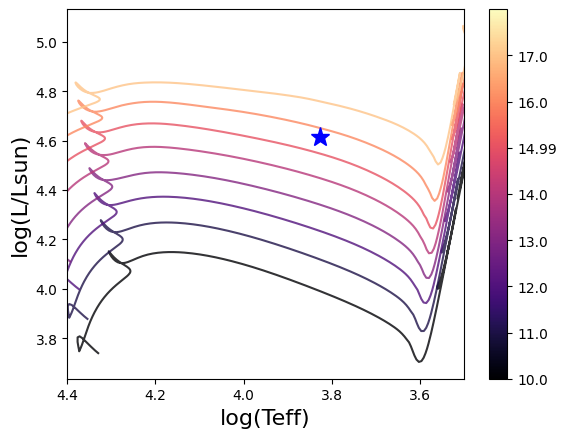

In [312]:
cmap = matplotlib.colormaps['magma']
mist_list = [m10, m11, m12, m13, m14, m15, m16, m17]
masses = []
for ind, mod in enumerate(mist_list):
    plt.plot(mod['log_Teff'], mod['log_L'], alpha=0.8, linestyle='-', color=cmap(ind/len(mist_list)))
    masses.append(round(mod['star_mass'][0], 2))

plt.errorbar(np.log10(np.nanmedian(samples[:, 0])), np.log10(np.nanmedian(lums)/3.83e33), fmt='*', color='blue', markersize=14)

plt.xlabel('log(Teff)', fontsize=16)
plt.ylabel('log(L/Lsun)', fontsize=16)
plt.xlim(4.4, 3.5)

ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(mist_list)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_ticks(np.arange(0,len(mist_list)))
cbar.set_ticklabels(masses)

### Breakout 3:
In the Rubin era, what sources of archival data will be relevant? Review the specifications of the following missions and discuss their efficacy for archival progenitor identifications :
- Euclid
- HST/JWST
- Roman
- Rubin itself

### Bonus Problem :
For ZTF21aagppzg, compute the luminosity and the duration of the plateau phase, and use it to determine the total ejected mass using the recombination-powered lightcurve model given in [Matsumoto and Metzger 2022](https://arxiv.org/abs/2202.10478). How does the ejected mass compare to the progenitor mass you just derived above?